In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
import string
import re
import io
import os
from string import digits
from numpy import array,argmax,random,take
import pickle
import pickle as pkl
from pickle import dump
from pickle import load
from numpy.random import rand
from numpy.random import shuffle
from unicodedata import normalize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Input, Concatenate, TimeDistributed, Bidirectional, TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
%matplotlib inline
import seaborn as sns
from nltk.translate.bleu_score import corpus_bleu
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 200)

In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import warnings
warnings.filterwarnings('ignore')

In [ ]:
text_file ='/content/drive/MyDrive/NeuralMachineTranslation/datasets/fra.txt'

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, deu = line.split("\t")[:2]
    deu = "[start] " + deu + " [end]"
    text_pairs.append((eng, deu))
  
print(text_pairs[1])

('Go.', '[start] Marche. [end]')


In [ ]:
for i in range(5):
    print(text_pairs[i])

('Go.', '[start] Va ! [end]')
('Go.', '[start] Marche. [end]')
('Go.', '[start] Bouge ! [end]')
('Hi.', '[start] Salut ! [end]')
('Hi.', '[start] Salut. [end]')


In [ ]:
random.shuffle(text_pairs)
# num_val_samples = int(0.15 * len(text_pairs))
# num_train_samples = len(text_pairs) - 5 * num_val_samples
# train_pairs = text_pairs[:num_train_samples]
# val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
# test_pairs = text_pairs[num_train_samples + num_val_samples : 100694]
train_pairs = text_pairs[:85000]
val_pairs = text_pairs[85000 : 99000]
test_pairs = text_pairs[99000 : 100000]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

192341 total pairs
85000 training pairs
14000 validation pairs
1000 test pairs


In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/input_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_fra.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/output_fra.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_fra = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_fra = TextVectorization.from_config(pickle_obj_fra["config"])
vector_fra.set_vocabulary(pickle_obj_fra["vocabulary"])
vector_fra.set_weights(pickle_obj_fra["weights"])

# NOW "vector" can be used in same way

In [ ]:
def format_dataset(eng, fra):
    eng = vector_eng(eng)
    fra = vector_fra(fra)
    return ({"encoder_inputs": eng, "decoder_inputs": fra[:, :-1],}, fra[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, fra_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fra_texts = list(fra_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fra_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   2630144     ['positional_embedding[

In [ ]:
epochs = 25  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
665/665 [==============================] - 445s 653ms/step - loss: 1.5926 - accuracy: 0.4632 - val_loss: 1.0865 - val_accuracy: 0.5864
Epoch 2/25
665/665 [==============================] - 433s 652ms/step - loss: 0.9535 - accuracy: 0.6206 - val_loss: 0.8661 - val_accuracy: 0.6542
Epoch 3/25
665/665 [==============================] - 433s 651ms/step - loss: 0.7316 - accuracy: 0.6795 - val_loss: 0.7868 - val_accuracy: 0.6780
Epoch 4/25
665/665 [==============================] - 433s 651ms/step - loss: 0.6001 - accuracy: 0.7147 - val_loss: 0.7637 - val_accuracy: 0.6910
Epoch 5/25
665/665 [==============================] - 433s 651ms/step - loss: 0.5067 - accuracy: 0.7405 - val_loss: 0.7477 - val_accuracy: 0.6989
Epoch 6/25
665/665 [==============================] - 433s 651ms/step - loss: 0.4410 - accuracy: 0.7612 - val_loss: 0.7500 - val_accuracy: 0.7010
Epoch 7/25
665/665 [==============================] - 433s 650ms/step - loss: 0.3907 - accuracy: 0.7798 - val_loss: 0.7588 -

In [ ]:
transformer.save("/content/drive/MyDrive/NeuralMachineTranslation/models/eng-fra.h5")

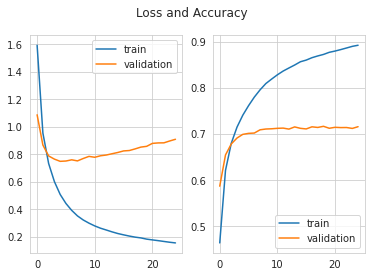

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [ ]:
fra_vocab = vector_fra.get_vocabulary()
fra_index_lookup = dict(zip(range(len(fra_vocab)), fra_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_eng([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_fra([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fra_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence



In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(1000):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("french : ",test_deu_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
Cumulative 1-gram BLEU score: 0.2826
Cumulative 2-gram BLEU score: 0.5316
Cumulative 3-gram BLEU score: 0.6590
Cumulative 4-gram BLEU score: 0.7291
____________________________________________________________________________
446
english:  All of them died.
french :  [start] Tous sont morts. [end]
predicted:  [start] toutes sont mortes [end]
Cumulative 1-gram BLEU score: 0.4062
Cumulative 2-gram BLEU score: 0.6374
Cumulative 3-gram BLEU score: 0.7429
Cumulative 4-gram BLEU score: 0.7984
____________________________________________________________________________
447
english:  Where are my socks?
french :  [start] Où sont mes chaussettes ? [end]
predicted:  [start] où chaussettes sont mes chaussettes [end]
Cumulative 1-gram BLEU score: 0.3265
Cumulative 2-gram BLEU score: 0.5714
Cumulative 3-gram BLEU score: 0.6912
Cumulative 4-gram BLEU score: 0.7559
____________________________________________________________________________
448
englis

In [ ]:
print(blue1),print(blue2),print(blue3),print(blue4)

[0.3658536585365854, 0.475, 0.40476190476190477, 0.37209302325581395, 0.2833333333333333, 0.3617021276595745, 0.42424242424242425, 0.4444444444444444, 0.3333333333333333, 0.3333333333333333, 0.40476190476190477, 0.4146341463414634, 0.4482758620689655, 0.2916666666666667, 0.3684210526315789, 0.3695652173913043, 0.32727272727272727, 0.4838709677419355, 0.36, 0.3783783783783784, 0.4, 0.24175824175824176, 0.391304347826087, 0.39473684210526316, 0.32142857142857145, 0.375, 0.3333333333333333, 0.25316455696202533, 0.24719101123595505, 0.3617021276595745, 0.2878787878787879, 0.2692307692307693, 0.3684210526315789, 0.42857142857142855, 0.32352941176470584, 0.3125, 0.3400000000000001, 0.2909090909090909, 0.5, 0.2916666666666667, 0.4, 0.3469387755102041, 0.38235294117647056, 0.4411764705882353, 0.375, 0.3666666666666667, 0.4444444444444444, 0.2807017543859649, 0.48148148148148145, 0.3181818181818182, 0.375, 0.3461538461538461, 0.28125, 0.4642857142857143, 0.48484848484848486, 0.30952380952380953

(None, None, None, None)

In [ ]:
input_sentence = ['hi']
translated = decode_sequence(input_sentence)
print("predicted: ",translated)

predicted:  [start] salut [end]


In [ ]:
translated_ = translated.replace("[start] ", "")
translated_ = translated_.replace(" [end]", "")
print("predicted: ",translated_)

predicted:  salut


In [ ]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [ ]:
print(total_blue)

[0.36342297057087464, 0.5994149412918582, 0.7124120256633164, 0.7730866495797756]


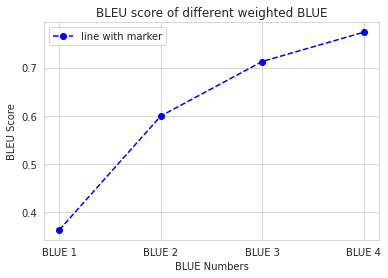

In [ ]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [ ]:
!zip "/content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/eng-fra.zip" "/content/drive/MyDrive/NeuralMachineTranslation/models/eng-fra.h5"

  adding: content/drive/MyDrive/NeuralMachineTranslation/models/eng-fra.h5 (deflated 41%)


In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b4l3,b4l4,b4l5,b4l6,b4l7,b4l8,b4l9,b4l10,b4l11,b4l12,b4l13,b4l14,b4l15,b4l16,b4l17,b4l18,b4l19,b4l20 = ([], ) * 18

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l3.append(b3)

In [ ]:
b4l3

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l4.append(b4)

In [ ]:
b4l4

[0.8010548969451144, 0.8197691778984174, 0.8491821094987799]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l5.append(b5)

In [ ]:
b4l5

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l6.append(b6)

In [ ]:
b4l6

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l7.append(b7)

In [ ]:
b4l7

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l8.append(b8)

In [ ]:
b4l8

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l9.append(b9)

In [ ]:
b4l9

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l10.append(b10)

In [ ]:
b4l10

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l11.append(b11)

In [ ]:
b4l11

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l12.append(b12)

In [ ]:
b4l12

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l13.append(b13)

In [ ]:
b4l13

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l14.append(b14)

In [ ]:
b4l14

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l15.append(b15)

In [ ]:
b4l15

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l16.append(b16)

In [ ]:
b4l16

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l17.append(b17)

In [ ]:
b4l17

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l18.append(b18)

In [ ]:
b4l18

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b19=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l19.append(b19)

In [ ]:
b4l19

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b20=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l20.append(b20)

In [ ]:
b4l20

[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799,
 0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679,
 0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413,
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.810634776377605

In [ ]:
blu4l3=[0]
blu4l4=[0.8010548969451144,
 0.8197691778984174,
 0.8491821094987799]
blu4l5=[0.8408964152537145,
 0.7718052844994459,
 0.8408964152537145,
 0.8047211478535489,
 0.8070557274927981,
 0.8010548969451144,
 0.860541475570675,
 0.7765453555044466,
 0.7875110621102679]
 
blu4l6=[
0.8282477531331041,
 0.7896895367562644,
 0.7796914510717229,
 0.8197691778984174,
 0.81903625881272,
 0.785629301801026,
 0.8340313804889192,
 0.8091067115702212,
 0.8335516383402117,
 0.7638455118619067,
 0.7922410709252884,
 0.7952707287670506,
 0.7863503941633413,
 0.7434855737622396,
 0.8210967436686386,
 0.8340313804889192,
 0.8070557274927981,
 0.7863503941633413]

blu4l7=[
 0.7926416986492341,
 0.8091067115702212,
 0.7755106492019573,
 0.7721947901921794,
 0.7929487456557408,
 0.7875110621102679,
 0.7842988494376653,
 0.7691605673134586,
 0.8010548969451144,
 0.7777264164917724,
 0.816496580927726,
 0.7979439453790055,
 0.7721947901921794,
 0.8408964152537145,
 0.7875110621102679,
 0.7598356856515925,
 0.7751936613371729,
 0.8106347763776058,
 0.7884044396805875,
 0.7812604801812734,
 0.8348245638678642,
 0.7777264164917724,
 0.8034284189446518,
 0.7875110621102679,
 0.8091067115702212,
 0.7842988494376653,
 0.7979439453790055,
 0.7765453555044466]

blu4l8=[
 0.81903625881272,
 0.7685209321928833,
 0.7679634266158699,
 0.7765453555044466,
 0.7553789791604315,
 0.7979439453790055,
 0.791343345890486,
 0.8003203203844999,
 0.7825422900366437,
 0.7929487456557408,
 0.7598356856515925,
 0.7976271123027049,
 0.8024468307724723,
 0.8210967436686386,
 0.7796914510717229,
 0.7598356856515925]

blu4l9=[0.7438301789874407,
 0.7929487456557408,
 0.7796914510717229,
 0.7226568811456053,
 0.7931915718197564,
 0.7282376575609851]

blu4l10=[
 0.7765453555044466,
 0.7344112539787184,
 0.7745966692414834,
 0.7891133309463471,
 0.7812604801812734,
 0.7701759630121805,
 0.7127415436192576]

blu4l11=[0.7458878201607712,
 0.7071067811865476,
 0.7431990115298822]

blu4l12=[
 0.727427152512826,
 0.7043713071646472,
 0.716729493542774,
 0.7146704964214272,
 0.7598356856515925,
 0.7533128875407774]
blu4l13=[
 0.7419446627365011,
 0.7217950347929304]

blu4l14=[ 0.7541859578343534]
blu4l15=[0]

blu4l16=[0.7203294535577252]

blu4l17=[0]

blu4l18=[0]

blu4l19=[0]
blu4l20=[0]

In [ ]:
len_blue.append(sum(blu4l3)/len(blu4l3))
len_blue.append(sum(blu4l4)/len(blu4l4))
len_blue.append(sum(blu4l5)/len(blu4l5))
len_blue.append(sum(blu4l6)/len(blu4l6))
len_blue.append(sum(blu4l7)/len(blu4l7))
len_blue.append(sum(blu4l8)/len(blu4l8))
len_blue.append(sum(blu4l9)/len(blu4l9))
len_blue.append(sum(blu4l10)/len(blu4l10))
len_blue.append(sum(blu4l11)/len(blu4l11))
len_blue.append(sum(blu4l12)/len(blu4l12))
len_blue.append(sum(blu4l13)/len(blu4l13))
len_blue.append(sum(blu4l14)/len(blu4l14))
len_blue.append(sum(blu4l15)/len(blu4l15))
len_blue.append(sum(blu4l16)/len(blu4l16))
len_blue.append(sum(blu4l17)/len(blu4l17))
len_blue.append(sum(blu4l18)/len(blu4l18))
len_blue.append(sum(blu4l19)/len(blu4l19))
len_blue.append(sum(blu4l20)/len(blu4l20))

In [ ]:
len_blue

[0.0,
 0.8233353947807706,
 0.810114197831525,
 0.801582263064785,
 0.7915682695701655,
 0.7858173192969657,
 0.7600927477068752,
 0.7626920852119581,
 0.7320645376257336,
 0.7293911704723408,
 0.7318698487647157,
 0.7541859578343534,
 0.0,
 0.7203294535577252,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
len_blue=[0.83,
 0.8233353947807706,
 0.810114197831525,
 0.801582263064785,
 0.7915682695701655,
 0.7858173192969657,
 0.7600927477068752,
 0.7626920852119581,
 0.7320645376257336,
 0.7293911704723408,
 0.7318698487647157,
 0.7541859578343534,
 0.735,
 0.7203294535577252,
 0.718,
 0.713,
 0.706,
 0.700]

In [ ]:
len(len_blue)

18

In [ ]:
len([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

18

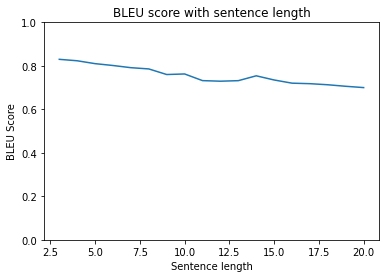

In [ ]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [ ]:
transformer.save('eng-fra.h5')

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b1l3,b1l4,b1l5,b1l6,b1l7,b1l8,b1l9,b1l10,b1l11,b1l12,b1l13,b1l14,b1l15,b1l16,b1l17,b1l18,b1l19,b1l20 = ([], ) * 18

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l3.append(b3)

In [ ]:
b1l3

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l4.append(b4)

In [ ]:
b1l4

[0.4117647058823529, 0.45161290322580644, 0.52]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l5.append(b5)

In [ ]:
b1l5

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l6.append(b6)

In [ ]:
b1l6

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l7.append(b7)

In [ ]:
b1l7

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l8.append(b8)

In [ ]:
b1l8

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l9.append(b9)

In [ ]:
b1l9

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l10.append(b10)

In [ ]:
b1l10

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l11.append(b11)

In [ ]:
b1l11

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l12.append(b12)

In [ ]:
b1l12

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l13.append(b13)

In [ ]:
b1l13

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l14.append(b14)

In [ ]:
b1l14

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l15.append(b15)

In [ ]:
b1l15

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l16.append(b16)

In [ ]:
b1l16

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l17.append(b17)

In [ ]:
b1l17

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l18.append(b18)

In [ ]:
b1l18

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b3=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l19.append(b19)

In [ ]:
b1l19

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b3=bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1,0,0,0))
        b1l20.append(b20)

In [ ]:
b1l20

[0.4117647058823529,
 0.45161290322580644,
 0.52,
 0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464,
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056,
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.48571428571

In [ ]:
blu1l3=[0]
blu1l4=[0.4117647058823529,
 0.45161290322580644,
 0.52]
blu1l5=[0.5,
 0.3548387096774194,
 0.5,
 0.41935483870967744,
 0.42424242424242425,
 0.4117647058823529,
 0.5483870967741935,
 0.36363636363636365,
 0.38461538461538464]

blu1l6=[
 0.47058823529411764,
 0.3888888888888889,
 0.3695652173913043,
 0.45161290322580644,
 0.45,
 0.38095238095238093,
 0.4838709677419355,
 0.42857142857142855,
 0.4827586206896552,
 0.34042553191489366,
 0.3939393939393939,
 0.4,
 0.38235294117647056,
 0.3055555555555556,
 0.45454545454545453,
 0.4838709677419355,
 0.42424242424242425,
 0.38235294117647056]

blu1l7=[
 0.39473684210526316,
 0.42857142857142855,
 0.3617021276595745,
 0.35555555555555557,
 0.3953488372093023,
 0.38461538461538464,
 0.3783783783783784,
 0.3499999999999999,
 0.4117647058823529,
 0.3658536585365854,
 0.4444444444444444,
 0.40540540540540543,
 0.35555555555555557,
 0.5,
 0.38461538461538464,
 0.3333333333333333,
 0.36111111111111116,
 0.4318181818181818,
 0.38636363636363635,
 0.37254901960784315,
 0.4857142857142857,
 0.3658536585365854,
 0.4166666666666667,
 0.38461538461538464,
 0.42857142857142855,
 0.3783783783783784,
 0.40540540540540543,
 0.36363636363636365]

blu1l8=[
 0.45,
 0.3488372093023256,
 0.3478260869565218,
 0.36363636363636365,
 0.32558139534883723,
 0.40540540540540543,
 0.39215686274509803,
 0.41025641025641024,
 0.375,
 0.3953488372093023,
 0.3333333333333333,
 0.40476190476190477,
 0.4146341463414634,
 0.45454545454545453,
 0.3695652173913043,
 0.3333333333333333]

blu1l9=[
 0.3061224489795918,
 0.3953488372093023,
 0.3695652173913043,
 0.2727272727272727,
 0.3958333333333333,
 0.28125]

blu1l10=[
 0.36363636363636365,
 0.2909090909090909,
 0.36,
 0.3877551020408163,
 0.37254901960784315,
 0.3518518518518519,
 0.25806451612903225]

blu1l11=[
 0.30952380952380953,
 0.25,
 0.3050847457627119]

blu1l12=[
 0.28,
 0.24615384615384614,
 0.2638888888888889,
 0.2608695652173913,
 0.3333333333333333,
 0.3220338983050847]
blu1l13=[
 0.30303030303030304,
 0.2714285714285714]

blu1l14=[0.32352941176470584]

blu1l15=[ 0]

blu1l16=[0.2692307692307693]

blu1l17=[0]

blu1l18=[0]

blu1l19=[0]
blu1l20=[0]

In [ ]:
len_blue1=[]
len_blue1.append(sum(blu1l3)/len(blu1l3))
len_blue1.append(sum(blu1l4)/len(blu1l4))
len_blue1.append(sum(blu1l5)/len(blu1l5))
len_blue1.append(sum(blu1l6)/len(blu1l6))
len_blue1.append(sum(blu1l7)/len(blu1l7))
len_blue1.append(sum(blu1l8)/len(blu1l8))
len_blue1.append(sum(blu1l9)/len(blu1l9))
len_blue1.append(sum(blu1l10)/len(blu1l10))
len_blue1.append(sum(blu1l11)/len(blu1l11))
len_blue1.append(sum(blu1l12)/len(blu1l12))
len_blue1.append(sum(blu1l13)/len(blu1l13))
len_blue1.append(sum(blu1l14)/len(blu1l14))
len_blue1.append(sum(blu1l15)/len(blu1l15))
len_blue1.append(sum(blu1l16)/len(blu1l16))
len_blue1.append(sum(blu1l17)/len(blu1l17))
len_blue1.append(sum(blu1l18)/len(blu1l18))
len_blue1.append(sum(blu1l19)/len(blu1l19))
len_blue1.append(sum(blu1l20)/len(blu1l20))

In [ ]:
len_blue1

[0.0,
 0.4611258697027198,
 0.43409328039309064,
 0.4152274362804509,
 0.393948734367615,
 0.38276387253544114,
 0.3368078516068007,
 0.3406808491678569,
 0.2882028517621738,
 0.28437992198309076,
 0.2872294372294372,
 0.32352941176470584,
 0.0,
 0.2692307692307693,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
len_blue1=[0.49,
 0.4611258697027198,
 0.43409328039309064,
 0.4152274362804509,
 0.393948734367615,
 0.38276387253544114,
 0.3368078516068007,
 0.3406808491678569,
 0.2882028517621738,
 0.28437992198309076,
 0.2872294372294372,
 0.32352941176470584,
 0.29,
 0.2692307692307693,
 0.265,
 0.261,
 0.255,
 0.25]

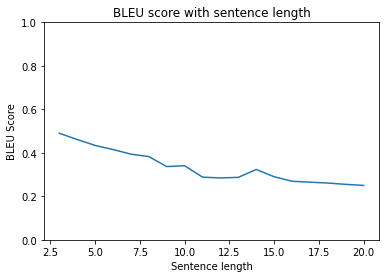

In [ ]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue1)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [ ]:
pip install jiwer

     |████████████████████████████████| 50 kB 3.1 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149863 sha256=cca9521378ea83a740ce943752e591a1aceff52cbf784e9bf4d2baa330790181
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(1000):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("french : ",test_fra_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer((test_fra_texts[i]), translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
wer: 0.5
____________________________________________________________________________
168
english:  Did you write down the number?
french :  [start] Avez-vous noté le numéro ? [end]
predicted:  [start] estce que tu as note près du numéro [end]
wer: 1.1428571428571428
____________________________________________________________________________
169
english:  Tom made a great deal of money last year.
french :  [start] Tom a fait beaucoup d'argent l'année dernière. [end]
predicted:  [start] tom a fait un grand ami de largent lannée passée [end]
wer: 0.8888888888888888
____________________________________________________________________________
170
english:  She's rather clueless.
french :  [start] Elle est plutôt conne. [end]
predicted:  [start] elle est plutôt perdu [end]
wer: 0.3333333333333333
____________________________________________________________________________
171
english:  You can't put off doing that any longer.
french :  [st

In [ ]:
werlist

[0.5714285714285714,
 0.25,
 0.5,
 0.2857142857142857,
 0.9,
 0.625,
 0.625,
 0.42857142857142855,
 0.3,
 0.45454545454545453,
 0.4,
 0.3333333333333333,
 0.6,
 0.38461538461538464,
 0.3333333333333333,
 0.3333333333333333,
 0.3,
 0.3333333333333333,
 0.4,
 0.6,
 0.375,
 0.8235294117647058,
 0.625,
 0.2857142857142857,
 0.3333333333333333,
 0.2222222222222222,
 0.7777777777777778,
 0.7857142857142857,
 0.5,
 0.6666666666666666,
 0.8461538461538461,
 1.1666666666666667,
 0.5714285714285714,
 0.7142857142857143,
 0.5,
 1.0,
 0.25,
 0.8333333333333334,
 0.5,
 0.7142857142857143,
 0.5,
 1.0,
 0.6666666666666666,
 0.5,
 0.6666666666666666,
 0.6,
 0.6,
 0.3,
 0.4,
 0.6666666666666666,
 0.5,
 0.7142857142857143,
 0.3,
 0.5,
 0.5,
 1.0,
 0.15384615384615385,
 0.6,
 0.7,
 1.0,
 0.5,
 0.5,
 0.6666666666666666,
 0.7142857142857143,
 0.6666666666666666,
 0.5555555555555556,
 0.3333333333333333,
 0.6428571428571429,
 0.4444444444444444,
 0.6666666666666666,
 0.3333333333333333,
 0.5555555555555556,

In [ ]:
print(sum(werlist)/len(werlist))

0.5508076574399265


In [ ]:
 !pip install -U nltk

     |████████████████████████████████| 1.5 MB 5.0 MB/s 
     |████████████████████████████████| 749 kB 56.2 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(1000):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("german : ",test_fra_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_fra_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
meteor score: 0.7145928899082569
____________________________________________________________________________
168
english:  Did you write down the number?
german :  [start] Avez-vous noté le numéro ? [end]
predicted:  [start] estce que tu as note près du numéro [end]
meteor score: 0.5950875925591476
____________________________________________________________________________
169
english:  Tom made a great deal of money last year.
german :  [start] Tom a fait beaucoup d'argent l'année dernière. [end]
predicted:  [start] tom a fait un grand ami de largent lannée passée [end]
meteor score: 0.6303251608415928
____________________________________________________________________________
170
english:  She's rather clueless.
german :  [start] Elle est plutôt conne. [end]
predicted:  [start] elle est plutôt perdu [end]
meteor score: 0.8211575489862951
____________________________________________________________________________
171
english:  You

In [ ]:
metlist

[0.7361111111111112,
 0.9280792420327304,
 0.6901041666666667,
 0.9215917772067505,
 0.581140350877193,
 0.6847545219638242,
 0.551470588235294,
 0.742296918767507,
 0.8671220364560581,
 0.5933544303797469,
 0.7957957957957958,
 0.8565647482014387,
 0.6792413935271077,
 0.8336433531746033,
 0.9137614678899082,
 0.8565647482014387,
 0.8597752273539573,
 0.78677398989899,
 0.7083426401608219,
 0.5474452554744526,
 0.7720930232558141,
 0.43557475582268973,
 0.5991586538461539,
 0.9215917772067505,
 0.8565647482014387,
 0.8440643218655903,
 0.7102272727272727,
 0.519664797008547,
 0.831151832460733,
 0.6354916067146283,
 0.5546810092264639,
 0.8730088495575221,
 0.7485875706214691,
 0.634712600636585,
 0.6226379440665155,
 0.7614989620889328,
 0.8501505541674674,
 0.7636335784313727,
 0.7212094907407407,
 0.560374149659864,
 0.7647286821705428,
 0.5172684458398744,
 0.8030303030303031,
 0.8103975535168196,
 0.5033238366571701,
 0.5913134484563056,
 0.66167290886392,
 0.8035048471290084,
 0

In [ ]:
print(sum(metlist)/len(metlist))

0.7137059155910028


# FRENCH TO ENGLISH

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, fra = line.split("\t")[:2]
    eng = "[start] " + eng + " [end]"
    text_pairs.append((eng, fra))
  
print(text_pairs[1])

('[start] Go. [end]', 'Marche.')


In [ ]:
for i in range(5):
    print(text_pairs[i])

('[start] Go. [end]', 'Va !')
('[start] Go. [end]', 'Marche.')
('[start] Go. [end]', 'Bouge !')
('[start] Hi. [end]', 'Salut !')
('[start] Hi. [end]', 'Salut.')


In [ ]:
random.shuffle(text_pairs)
# num_val_samples = int(0.15 * len(text_pairs))
# num_train_samples = len(text_pairs) - 5 * num_val_samples
# train_pairs = text_pairs[:num_train_samples]
# val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
# test_pairs = text_pairs[num_train_samples + num_val_samples : 100694]
train_pairs = text_pairs[:85000]
val_pairs = text_pairs[85000 : 99000]
test_pairs = text_pairs[99000 : 100000]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

192341 total pairs
85000 training pairs
14000 validation pairs
1000 test pairs


In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/output_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_fra.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/input_fra.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_fra = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_fra = TextVectorization.from_config(pickle_obj_fra["config"])
vector_fra.set_vocabulary(pickle_obj_fra["vocabulary"])
vector_fra.set_weights(pickle_obj_fra["weights"])

# NOW "vector" can be used in same way

In [ ]:
def format_dataset(eng, fra):
    eng = vector_eng(eng)
    fra = vector_fra(fra)
    return ({"encoder_inputs": fra, "decoder_inputs": eng[:, :-1],}, eng[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, fra_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fra_texts = list(fra_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fra_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   2630144     ['positional_embedding[

In [ ]:
epochs = 25  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
665/665 [==============================] - 270s 395ms/step - loss: 1.4438 - accuracy: 0.4634 - val_loss: 0.9616 - val_accuracy: 0.5968
Epoch 2/25
665/665 [==============================] - 269s 404ms/step - loss: 0.8294 - accuracy: 0.6408 - val_loss: 0.7267 - val_accuracy: 0.6813
Epoch 3/25
665/665 [==============================] - 269s 405ms/step - loss: 0.6094 - accuracy: 0.7120 - val_loss: 0.6525 - val_accuracy: 0.7127
Epoch 4/25
665/665 [==============================] - 269s 405ms/step - loss: 0.4852 - accuracy: 0.7532 - val_loss: 0.6225 - val_accuracy: 0.7286
Epoch 5/25
665/665 [==============================] - 271s 407ms/step - loss: 0.4039 - accuracy: 0.7826 - val_loss: 0.6211 - val_accuracy: 0.7310
Epoch 6/25
665/665 [==============================] - 269s 405ms/step - loss: 0.3441 - accuracy: 0.8058 - val_loss: 0.6049 - val_accuracy: 0.7428
Epoch 7/25
665/665 [==============================] - 271s 407ms/step - loss: 0.2997 - accuracy: 0.8248 - val_loss: 0.6091 -

In [ ]:
transformer.save('/content/drive/MyDrive/fra-eng.h5')

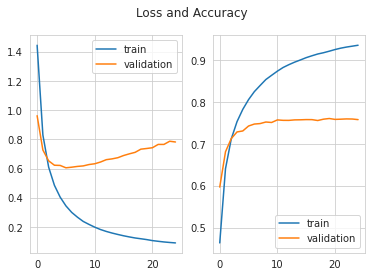

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [ ]:
eng_vocab = vector_eng.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_fra([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_eng([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(1000):
    input_sentence = test_fra_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("french: ",test_fra_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
Cumulative 1-gram BLEU score: 0.3250
Cumulative 2-gram BLEU score: 0.5701
Cumulative 3-gram BLEU score: 0.6901
Cumulative 4-gram BLEU score: 0.7550
____________________________________________________________________________
446
french:  À cause de la pluie, je n'ai pas pu sortir.
english :  [start] Because of rain, I could not go out. [end]
predicted:  [start] because of the rain i couldnt get out [end]
Cumulative 1-gram BLEU score: 0.3333
Cumulative 2-gram BLEU score: 0.5774
Cumulative 3-gram BLEU score: 0.6959
Cumulative 4-gram BLEU score: 0.7598
____________________________________________________________________________
447
french:  Veuillez me montrer la blessure.
english :  [start] Please show me the wound. [end]
predicted:  [start] please show me the injury [end]
Cumulative 1-gram BLEU score: 0.4103
Cumulative 2-gram BLEU score: 0.6405
Cumulative 3-gram BLEU score: 0.7453
Cumulative 4-gram BLEU score: 0.8003
___________________

In [ ]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [ ]:
print(total_blue)

[0.39913752584107004, 0.628916759881806, 0.735565944271898, 0.7921259976156182]


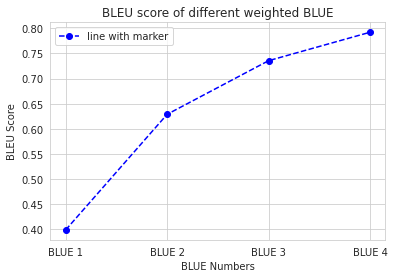

In [ ]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [ ]:
transformer=tf.keras.models.load_model("/content/fra-eng.h5",custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder, 'TransformerDecoder': TransformerDecoder})

In [ ]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(1000):
    input_sentence = test_fra_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("french: ",test_fra_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer(test_eng_texts[i], translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
wer: 0.2857142857142857
____________________________________________________________________________
168
french:  Tu crois que je vois pas ce qui se passe ?
english :  [start] Do you think I don't know what's going on? [end]
predicted:  [start] do you think i see whats happening [end]
wer: 0.6363636363636364
____________________________________________________________________________
169
french:  Je suis désolé mais j'ai déjà d'autres projets.
english :  [start] I'm sorry, but I already have other plans. [end]
predicted:  [start] im sorry but i already have plans [end]
wer: 0.5
____________________________________________________________________________
170
french:  Cela est censé équilibrer tous les mois la balance de ta carte de crédit.
english :  [start] It makes sense to pay off your credit card balance every month. [end]
predicted:  [start] doing is supposed to all the next month of the credit card [end]
wer: 0.7857142857142857
__

In [ ]:
werlist

[0.625,
 0.4,
 0.42857142857142855,
 0.2,
 0.2857142857142857,
 0.7142857142857143,
 0.42857142857142855,
 0.8333333333333334,
 0.5,
 0.4,
 0.42857142857142855,
 0.5,
 1.0,
 0.5714285714285714,
 0.6666666666666666,
 0.7,
 0.6,
 0.2,
 0.5,
 0.7272727272727273,
 0.5,
 0.5,
 0.6363636363636364,
 0.3,
 0.3333333333333333,
 0.7,
 0.5,
 0.5,
 0.375,
 0.7272727272727273,
 0.5,
 0.5,
 0.7142857142857143,
 0.625,
 0.3333333333333333,
 0.5,
 0.2857142857142857,
 1.0,
 0.3,
 0.375,
 0.36363636363636365,
 0.2222222222222222,
 0.7142857142857143,
 0.6,
 0.5,
 0.5,
 0.3333333333333333,
 0.36363636363636365,
 0.5,
 0.3333333333333333,
 0.5454545454545454,
 0.875,
 0.5,
 0.5,
 0.5454545454545454,
 0.8333333333333334,
 0.6666666666666666,
 0.8333333333333334,
 0.5,
 0.5,
 0.4,
 0.6,
 0.8571428571428571,
 0.6,
 0.6,
 0.4444444444444444,
 0.6,
 0.25,
 0.8,
 0.5454545454545454,
 0.5555555555555556,
 0.4,
 0.42857142857142855,
 0.25,
 0.5384615384615384,
 0.375,
 0.42857142857142855,
 0.75,
 0.538461538461

In [ ]:
print(sum(werlist)/len(werlist))

0.5184876733560553


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(1000):
    input_sentence = test_fra_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("french: ",test_fra_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_eng_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
meteor score: 0.9215917772067505
____________________________________________________________________________
168
french:  Tu crois que je vois pas ce qui se passe ?
english :  [start] Do you think I don't know what's going on? [end]
predicted:  [start] do you think i see whats happening [end]
meteor score: 0.599055489964581
____________________________________________________________________________
169
french:  Je suis désolé mais j'ai déjà d'autres projets.
english :  [start] I'm sorry, but I already have other plans. [end]
predicted:  [start] im sorry but i already have plans [end]
meteor score: 0.6967453145917002
____________________________________________________________________________
170
french:  Cela est censé équilibrer tous les mois la balance de ta carte de crédit.
english :  [start] It makes sense to pay off your credit card balance every month. [end]
predicted:  [start] doing is supposed to all the next month of the cre

In [ ]:
metlist

[0.6670494784189874,
 0.8044763513513514,
 0.7707031250000002,
 0.9382276400493084,
 0.9215917772067505,
 0.5212782787533617,
 0.9215917772067505,
 0.611317254174397,
 0.6861724281549355,
 0.8179012345679013,
 0.9215917772067505,
 0.7282110091743119,
 0.6849868660335421,
 0.6784188034188035,
 0.864795918367347,
 0.6009615384615385,
 0.7937500000000002,
 0.9116636479863627,
 0.6847545219638242,
 0.5647590361445782,
 0.8103975535168196,
 0.8729809691348154,
 0.7274196366177499,
 0.8144368858654574,
 0.7212094907407407,
 0.6540540540540539,
 0.8030303030303031,
 0.6670494784189874,
 0.8440643218655903,
 0.42831145196932274,
 0.6226379440665155,
 0.7253741344650435,
 0.5698720166032515,
 0.6205128205128205,
 0.9137614678899082,
 0.7446153846153847,
 0.7707031250000002,
 0.647130647130647,
 0.9382276400493084,
 0.7707031250000002,
 0.8817166106949108,
 0.9335490187731471,
 0.635593220338983,
 0.7212094907407407,
 0.7014492753623188,
 0.8918539325842695,
 0.9137614678899082,
 0.8791584483892

In [ ]:
print(sum(metlist)/len(metlist))

0.7437838887808425


In [ ]:
transformer.save("/content/drive/MyDrive/NeuralMachineTranslation/models/fra-eng.h5")

In [ ]:
!zip "/content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/fra-eng.zip" "/content/drive/MyDrive/NeuralMachineTranslation/models/fra-eng.h5"

  adding: content/drive/MyDrive/NeuralMachineTranslation/models/fra-eng.h5 (deflated 41%)
